In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag')
isValidColumn <- function(x) ! x %in% invalids

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.0189)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

# Predict Red

In [8]:
df3 <- read.csv("../data/middle/sp1.csv", stringsAsFactors=FALSE)

In [9]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [10]:
allFeatures <- c(colnames(df3))
features <- Filter(isValidColumn, allFeatures)

In [11]:
expr <- paste("flag ~ ", paste(features, collapse=" + "))

In [12]:
folds3 <- createFolds(df3$flag)

In [13]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 37/70 = 0.528571
As for Blue: correct/predict = 12/34 = 0.352941

Fold2
As for Red: correct/predict = 48/74 = 0.648649
As for Blue: correct/predict = 19/30 = 0.633333

Fold3
As for Red: correct/predict = 39/66 = 0.590909
As for Blue: correct/predict = 18/38 = 0.473684

Fold4
As for Red: correct/predict = 48/72 = 0.666667
As for Blue: correct/predict = 21/32 = 0.656250

Fold5
As for Red: correct/predict = 43/77 = 0.558442
As for Blue: correct/predict = 11/27 = 0.407407

Fold6
As for Red: correct/predict = 39/65 = 0.600000
As for Blue: correct/predict = 18/38 = 0.473684

Fold7
As for Red: correct/predict = 46/77 = 0.597403
As for Blue: correct/predict = 14/28 = 0.500000

Fold8
As for Red: correct/predict = 38/56 = 0.678571
As for Blue: correct/predict = 27/49 = 0.551020

Fold9
As for Red: correct/predict = 41/63 = 0.650794
As for Blue: correct/predict = 23/41 = 0.560976

Fold10
As for Red: correct/predict = 43/65 = 0.661538
As for Blue: correct/predict

In [14]:
fit3 <- rpart(expr, data=df3, method="class")

In [15]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01113586

In [16]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     Curve             DistSignal       
 [5] Jerk              ManBicycleCount   Pitch             RiskFactor       
 [9] RoadType          Speed             SteeringAngle     TimeHeadway      

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.031737      0   1.00000 1.00000 0.035602
2 0.024499      5   0.83519 0.97105 0.035465
3 0.018931      6   0.81069 0.95991 0.035406
4 0.011136      8   0.77283 0.93764 0.035278
5 0.010579     12   0.72606 0.94432 0.035318
6 0.010000     17   0.66592 0.94432 0.035318


In [17]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.03173719      0 1.0000000 1.0000000 0.03560167
2 0.02449889      5 0.8351893 0.9710468 0.03546495
3 0.01893096      6 0.8106904 0.9599109 0.03540618
4 0.01113586      8 0.7728285 0.9376392 0.03527822
5 0.01057906     12 0.7260579 0.9443207 0.03531807
6 0.01000000     17 0.6659243 0.9443207 0.03531807

Variable importance
       RiskFactor             Speed          RoadType AccelerationSpeed 
               13                11                11                 9 
            Pitch             Curve       TimeHeadway        DistSignal 
                7                 7                 7                 6 
    AheadDistance   TimeToCollision     SteeringAngle              Jerk 
                6                 5                 4                 4 
           Engine   ManBicycleCount          PathType         LaneCount 
                3                 2      

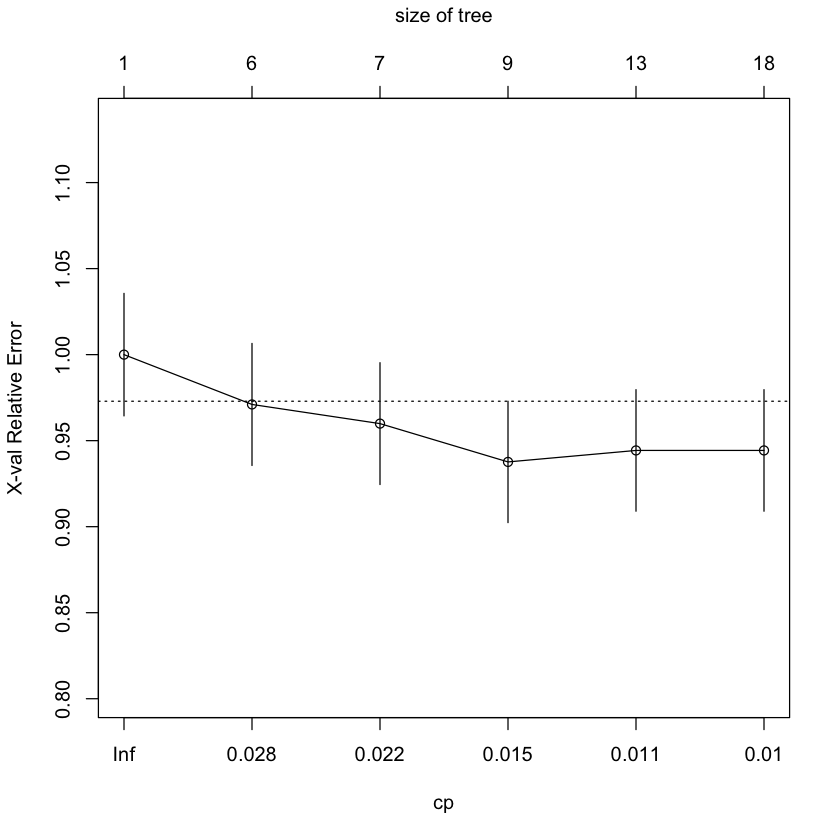

In [18]:
plotcp(fit3)